In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import numpy as np
from aenum import MultiValueEnum
from matplotlib.colors import ListedColormap, BoundaryNorm
import geopandas as gpd
from sentinelhub import BBox, CRS, DataCollection, MimeType, SentinelHubRequest, SHConfig
from mpl_toolkits.axes_grid1 import make_axes_locatable
from eolearn.core import SaveTask, LoadTask, FeatureType, LinearWorkflow
from eolearn.io import SentinelHubInputTask, SentinelHubDemTask, SentinelHubInputBase, get_available_timestamps


ModuleNotFoundError: No module named 'geopandas'

In [3]:
# In case you put the credentials into the configuration file you can leave this unchanged

INSTANCE_ID = '31aacbb6-8ad8-43f5-b19d-84a8302c2a3e'
CLIENT_ID = '8c799cf6-53fa-4f98-a3ff-417cdc658b57'
CLIENT_SECRET = '13[,;5upS5%e3@oZk?J^1:)Fu?*.+0kF|,kD6re2'

In [4]:
config = SHConfig()

if CLIENT_ID and CLIENT_SECRET and INSTANCE_ID:
    config.instance_id = INSTANCE_ID
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if config.sh_client_id == '' or config.sh_client_secret == '' or config.instance_id == '':
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")

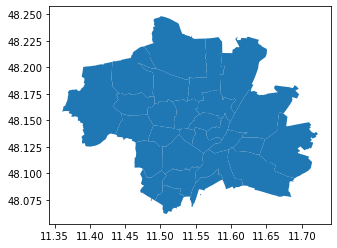

In [5]:
# import munich geojson
munich = gpd.read_file("./munich.geojson")

# name_dict = {name:i for (i, name) in enumerate(munich.name)}
# interested_area = munich.iloc[name_dict['Hadern']]
# bbox_interested_area = interested_area.geometry.bounds
munich.plot()

# Set the time interval and BBox

In [7]:
# region of interest

interested_area = munich.geometry.unary_union
bbox_interested_area = interested_area.bounds
roi_bbox = BBox(bbox=bbox_interested_area, crs=CRS.WGS84)
print(bbox_interested_area)
# time interval of downloaded data
time_interval = ('2020-04-01', '2020-05-01')

# maximal cloud coverage (based on Sentinel-2 provided tile metadata)
maxcc = .8

# resolution of the request (in metres)(since we use Sentinel-2)
resolution = 20

# time difference parameter (minimum allowed time difference; if two observations are closer than this, they will be mosaicked into one observation)
time_difference = datetime.timedelta(hours=2)

(11.36078, 48.061602, 11.722878, 48.24822)


In [59]:
input_task = SentinelHubInputTask(
    data_collection=DataCollection.LANDSAT8,
    bands=['B01','B02','B03','B04','B05','B06','B07','B08','B09','B10','B11','BQA'],
    bands_feature=(FeatureType.DATA, 'L1C_data'),
    additional_data=[(FeatureType.MASK, 'dataMask')],
    resolution=resolution,
    maxcc=maxcc,
    time_difference=time_difference,
    config=config,
    max_threads=3
)

'''
add_l2a_and_scl = SentinelHubInputTask(
    data_collection=DataCollection.LANDSAT8,
    bands=['B01','B02','B03','B04','B05','B06','B07','B08','B09','B10','B11','BQA'],
    bands_feature=(FeatureType.DATA, 'L2A_data'),
    # additional_data=[(FeatureType.MASK, 'SCL')],
    resolution=resolution,
    maxcc=maxcc,
    time_difference=time_difference,
    config=config,
    max_threads=3
)

'''

"\nadd_l2a_and_scl = SentinelHubInputTask(\n    data_collection=DataCollection.LANDSAT8,\n    bands=['B01','B02','B03','B04','B05','B06','B07','B08','B09','B10','B11','BQA'],\n    bands_feature=(FeatureType.DATA, 'L2A_data'),\n    # additional_data=[(FeatureType.MASK, 'SCL')],\n    resolution=resolution,\n    maxcc=maxcc,\n    time_difference=time_difference,\n    config=config,\n    max_threads=3\n)\n\n"

# Save eopatch

In [1]:
save = SaveTask('io_example', overwrite_permission=2, compress_level=1)

NameError: name 'SaveTask' is not defined

In [53]:
workflow = LinearWorkflow(input_task,save)

result = workflow.execute({
    input_task: {'bbox': roi_bbox, 'time_interval': time_interval},
    save: {'eopatch_folder': 'eopatch'}
})

# Check contents of eopatch

In [54]:
eopatch = result.eopatch()
eopatch

EOPatch(
  data: {
    L1C_data: numpy.ndarray(shape=(3, 1082, 1312, 12), dtype=float32)
    L2A_data: numpy.ndarray(shape=(3, 1082, 1312, 12), dtype=float32)
  }
  mask: {
    dataMask: numpy.ndarray(shape=(3, 1082, 1312, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.8
    service_type: 'processing'
    size_x: 1312
    size_y: 1082
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: None
  }
  bbox: BBox(((11.36078, 48.061602), (11.722878, 48.24822)), crs=CRS('4326'))
  timestamp: [datetime.datetime(2020, 4, 7, 10, 3, 24), ..., datetime.datetime(2020, 4, 23, 10, 3, 17)], length=3
)

In [25]:
eopatch["timestamp"]

[datetime.datetime(2020, 4, 7, 10, 3, 24),
 datetime.datetime(2020, 4, 16, 9, 57, 9),
 datetime.datetime(2020, 4, 23, 10, 3, 17)]

In [29]:
# Check the data shape, [time, image width, image height, bands number]
print(eopatch.data['L1C_data'].shape)
print(eopatch.mask['dataMask'].shape)

(3, 1082, 1312, 12)
(3, 1082, 1312, 1)


In [33]:
# here select the image whose datetime is second in the eopatch["timestamp"]
eopatch.mask['dataMask'][1].shape

(1082, 1312, 1)

In [32]:
# where data mask = False means there is no valid pixel
eopatch.mask['dataMask'][1]

array([[[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]],

       [[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]],

       [[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]],

       [[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]],

       [[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]]])

In [62]:
# image of the first date in datelist 
eopatch["timestamp"][0]

datetime.datetime(2020, 4, 7, 10, 3, 24)

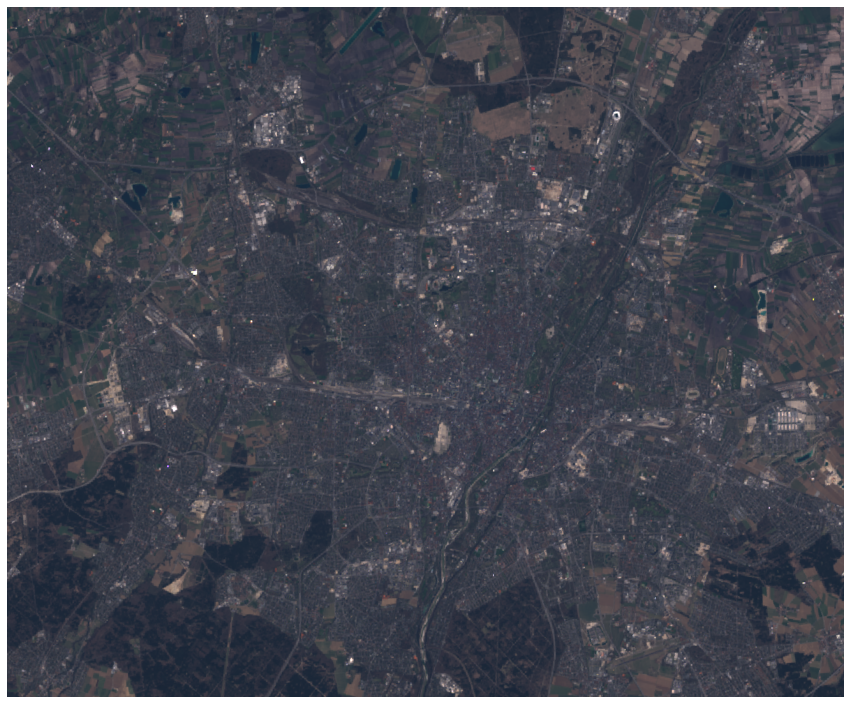

In [63]:
plt.figure(figsize=(15,15))
plt.imshow(np.clip(eopatch.data['L1C_data'][0][..., [3,2,1]] * 2.5, 0, 1), vmin=0, vmax=1);
plt.axis(False);

In [64]:
# image of the second date in datelist 

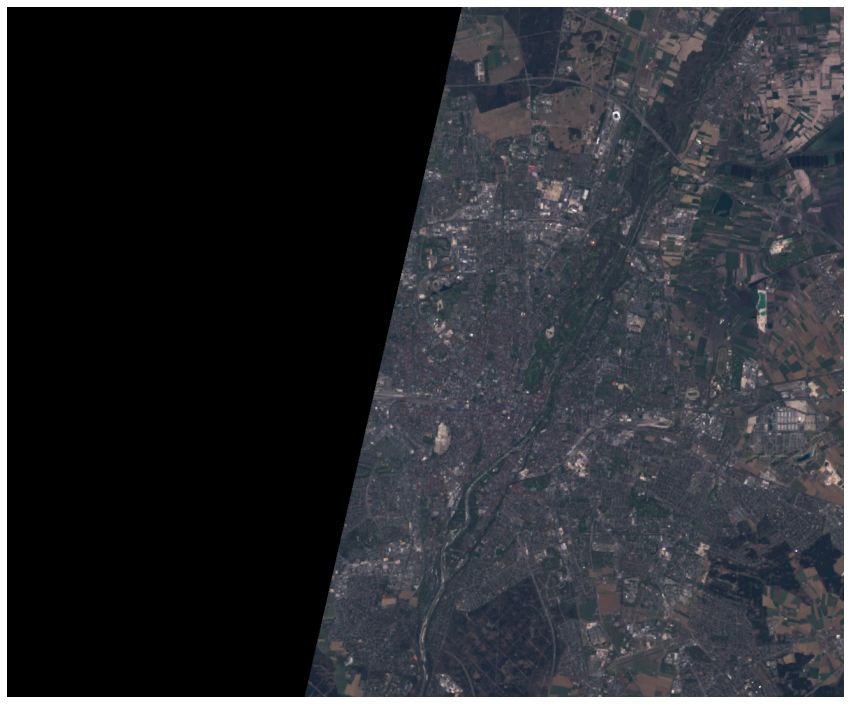

In [65]:
plt.figure(figsize=(15,15))
plt.imshow(np.clip(eopatch.data['L1C_data'][1][..., [3,2,1]] * 2.5, 0, 1), vmin=0, vmax=1);
plt.axis(False);

In [66]:
# Seems no difference. No need to use L2A.

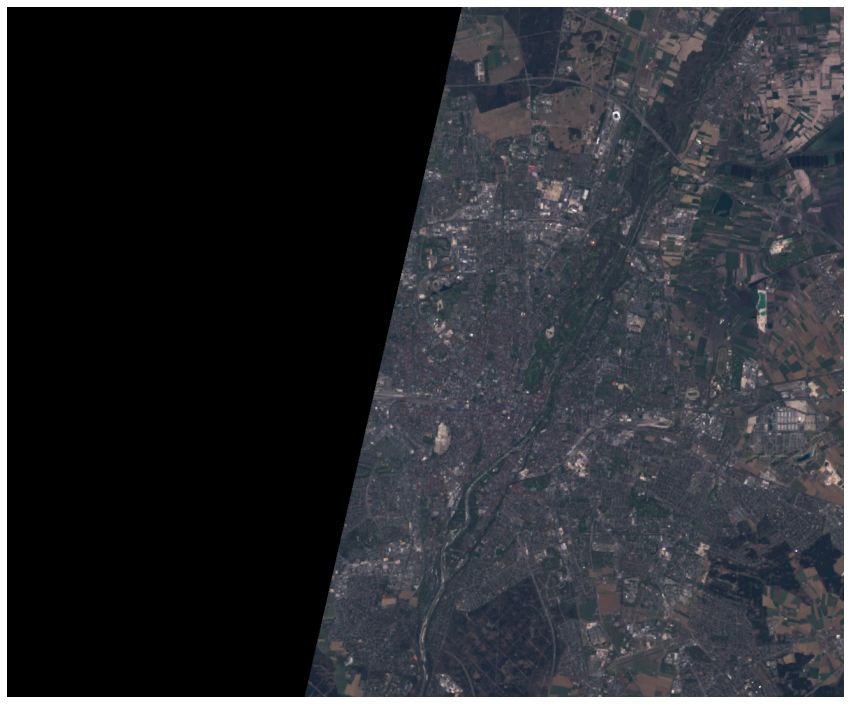

In [67]:
plt.figure(figsize=(15,15))
plt.imshow(np.clip(eopatch.data['L2A_data'][1][..., [3,2,1]] * 2.5, 0, 1), vmin=0, vmax=1);
plt.axis(False);